In [ ]:
# Imports

# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Preprocessing
from sklearn.preprocessing import LabelEncoder, label_binarize

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, recall_score, roc_auc_score, roc_curve
)


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model training (XGBoost)
import xgboost as xgb

# Utility
import time
import joblib  # For saving/loading models




In [ ]:
# Accès à Google Drive (pour Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chargement des fichiers CSV depuis Google Drive
folder_path = '/content/drive/MyDrive/data/'
files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]


In [ ]:
# Fusion des datasets
dfs = [pd.read_csv(folder_path + file) for file in files]
df = pd.concat(dfs, ignore_index=True)
print("Shape:", df.shape)


Shape: (2830743, 79)


In [ ]:
#  Nettoyage : suppression des doublons
df.drop_duplicates(inplace=True)
# Remplacement des valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Suppression finale des lignes encore incomplètes
df.dropna(inplace=True)

In [ ]:
# Supprimer les colonnes inutiles
columns_to_drop = [
                    ' Destination Port',' Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
                   ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
                   ' Bwd Avg Packets/Bulk', ' Subflow Fwd Bytes', ' Subflow Bwd Packets',
                   ' Subflow Bwd Bytes', ' Idle Std', ' Idle Max', ' Idle Min']
columns_to_drop_filtered = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop_filtered, inplace=True)

In [ ]:
# Séparation des features (X) et de la cible (y)
X = df.drop(' Label', axis=1)
y = df[' Label']


In [ ]:
# Encodage de la colonne de label
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Gestion du déséquilibre avec des poids
class_counts = Counter(y_train)
majority_class = max(class_counts, key=class_counts.get)
weights = {cls: class_counts[majority_class]/count for cls, count in class_counts.items()}
sample_weights = np.array([weights[label] for label in y_train])


In [ ]:
# Paramètres XGBoost optimisés
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'verbosity': 1
}


In [ ]:
# Préparation des DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Entraînement avec mesure du temps
start_train = time.time()
model = xgb.train(params, dtrain, num_boost_round=100)
end_train = time.time()
training_time = end_train - start_train
print("Temps d'entraînement (s) :", training_time)

Temps d'entraînement (s) : 739.6274139881134


In [ ]:
# Prédiction avec mesure du temps
start_pred = time.time()
y_pred_probs = model.predict(dtest)
end_pred = time.time()
prediction_time = end_pred - start_pred
print("Temps de prédiction (s) :", prediction_time)

Temps de prédiction (s) : 0.11753296852111816


In [ ]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9975087273881308


In [ ]:
# F1 Scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (macro):", f1_macro)
print("F1 Score (weighted):", f1_weighted)

F1 Score (macro): 0.8642253271001802
F1 Score (weighted): 0.9977389199171649


In [ ]:
# Recall (sensibilité)
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
print("Recall (macro):", recall_macro)
print("Recall (weighted):", recall_weighted)


Recall (macro): 0.9513384779249685
Recall (weighted): 0.9975087273881308


In [ ]:
#  Rapport de classification complet
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))


📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    419012
           1       0.44      0.99      0.61       390
           2       1.00      1.00      1.00     25603
           3       0.98      1.00      0.99      2057
           4       1.00      1.00      1.00     34569
           5       0.90      1.00      0.94      1046
           6       0.98      0.99      0.98      1077
           7       1.00      1.00      1.00      1186
           8       1.00      1.00      1.00         2
           9       0.64      1.00      0.78         7
          10       0.99      1.00      0.99     18139
          11       1.00      1.00      1.00       644
          12       0.76      0.70      0.73       294
          13       0.31      1.00      0.47         4
          14       0.38      0.59      0.47       130

    accuracy                           1.00    504160
   macro avg       0.82      0.95      0.86    504160

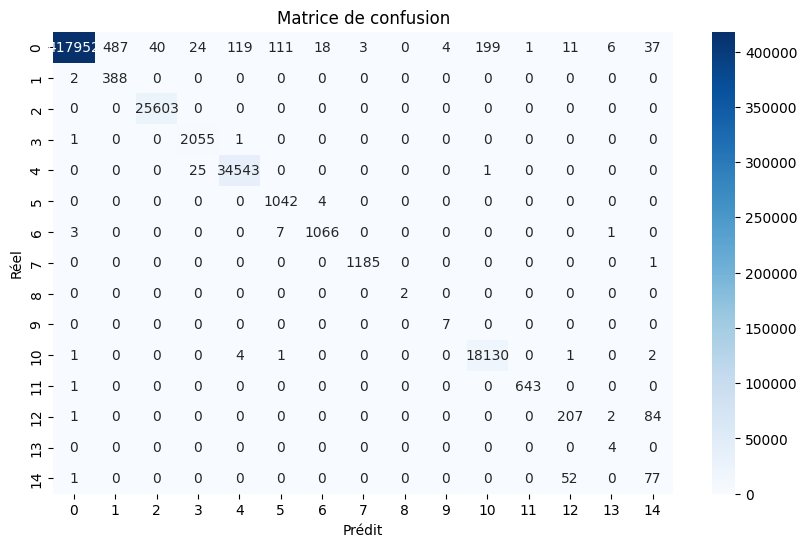

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


In [ ]:

# Binariser les labels pour le calcul AUC-ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
# y_pred_probs est déjà calculé : model.predict(dtest)

# Calcul du score AUC-ROC
auc_score = roc_auc_score(y_test_bin, y_pred, multi_class='ovr')
print("AUC-ROC Score (multi-class):", auc_score)

AUC-ROC Score (multi-class): 0.9998855143367767


In [ ]:
# Sauvegarder le modèle
joblib.dump(model, 'random_forest_model.pkl')
print(" Modèle sauvegardé sous le nom : random_forest_model.pkl")